

<b> Основные шаги</b>:

1.Открытие файла с данными и изучение общей информации

2.Подготовка данных

3.Анализ данных

4.Проверка гипотез

5.Вывод

# 1. Открытие файлов и изучение информации

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

print('-----Информация о тарифах -----')
print(tariffs.head(10))
print(tariffs.info())

print('-----Информация о звонках-----')
print(calls.head(10))
print(calls.info())

print('-----Информация об интернет сессиях-----')
print(internet.head(10))
print(internet.info())

print('-----Информация о сообщениях -----')
print(messages.head(10))
print(messages.info())


print('-----Информация о пользователях -----')
print(users.head(10))
print(users.info())


-----Информация о тарифах -----
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
-----Информация о звонках-----
       id 

<b> Вывод </b>

1. Во всех таблицах присутствует user_id , по пользователям можно объединить данные в один датафрейм.
2.Нулевые значения есть только в столбце churn_date, их убирать не будем, если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Для дальнейшей аналитики это не помешает.
3. Столбцы с датами нужно привести к типу данных - дата.

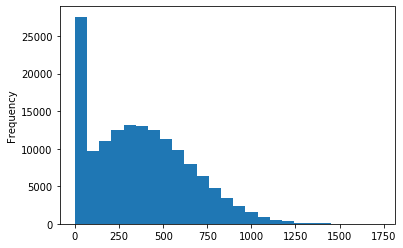

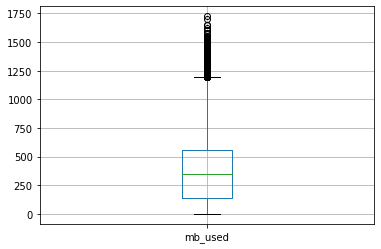

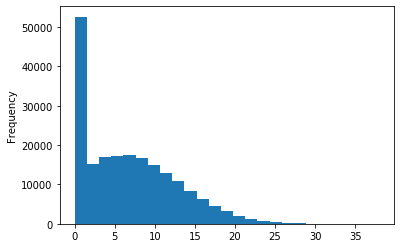

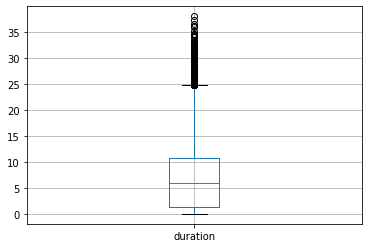

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64
count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64


In [2]:
#Интернет трафик

internet['mb_used'].plot(kind='hist',bins=25)
plt.show()
internet.boxplot(column=['mb_used'])
plt.show()

#Звонки

calls['duration'].plot(kind='hist',bins=25)
plt.show()
calls.boxplot(column=['duration'])
plt.show()
print(internet['mb_used'].describe())
print(calls['duration'].describe())



В данных интернет трафика и звонках присутствуют выбросы со значением = 0. Звонки с нулевой продолжительностью не являются ошибкой, это пропущенные звонки. Также есть клиенты, которые не пользуются интернетом, но при этом отправляют сообщения или звонят. Так как есть клиенты, которые пользуются только одним видом связи и это нормально - нулевые значения удалять не буду, они заплатили за использованный тариф и данные нужны для аналитики. Нужно учесть, что многие не используют полностью предоставляемые тарифные пакеты, могут только звонить, но не отправлять сообщения и не пользоваться интернетом, или наоборот практически не созваниваться, и вести коммуникацию в сети.
    
Также методом boxplot() видны выбросы в значениях больше обычного,крайне редко, кто тратит больше, чем 1200МБ за месяц, и наговаривает больше,чем на 25 минут за один звонок, но это не является аномалией и допустимые значения и для трафика и для продолжительности разговора, просто очень редкие.

# 2.Предобработка данных 

In [3]:
#Заменяю тип в столбце данных с датой на дату
#Оставляю в столбцах только месяц
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls['call_date'] = pd.DatetimeIndex(calls['call_date']).month

internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.DatetimeIndex(internet['session_date']).month

messages['message_date'] = pd.to_datetime(messages['message_date'],format = '%Y-%m-%d')
messages['message_date'] = pd.DatetimeIndex(messages['message_date']).month


In [4]:
#округляем продолжительность звонка до минут в большую сторону(по правилам тарифа)
calls['duration']=calls['duration'].apply(math.ceil)

#добавляю столбец с кол-вом сделанных звонков, если длительность 0 - это пропущенный
def count(row):
    duration = row['duration']

    if duration == 0:
        return 0
    else:
        return 1

calls['duration_count'] = calls.apply(count, axis=1)




In [5]:


from functools import reduce

#группируем таблицы по user_id и date(месяцу)
calls_group=calls.groupby(['user_id', 'call_date'], as_index=False).agg({'duration':'sum', 'duration_count':'sum'}) \
.rename(columns={'call_date': 'date'})

internet_group=internet.groupby(['user_id', 'session_date'], as_index=False).agg({'mb_used':'sum'}) \
.rename(columns={'session_date': 'date'})

messages_group=messages.groupby(['user_id', 'message_date'], as_index=False).agg({'id':'count'}) \
.rename(columns={'message_date': 'date', 'id': 'count_messages'})

#объединяем таблицы
#tarif_data=calls_group.merge(internet_group, on=['user_id', 'date'], how = 'outer') \
#.merge(messages_group, on=['user_id', 'date'], how = 'outer') \
#.merge(users, on='user_id',how = 'outer')

data_group = [calls_group, internet_group, messages_group]

tarif_data = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'date'],
                                            how='outer'), data_group) \
.merge(users, on='user_id',how = 'outer')


#Заменяем NaN на 0
tarif_data.fillna(0,inplace=True)

#переводим МБ в ГБ в столбце mb_used

tarif_data['mb_used']=tarif_data['mb_used'] / 1024
#округляем интернет-трафик за месяц в большую сторону(по правилам тарифа)

tarif_data['mb_used']=tarif_data['mb_used'].apply(math.ceil)

tarif_data=tarif_data.rename(columns={'mb_used': 'gb_used'})



In [6]:
tariffs=tariffs.rename(columns={'tariff_name': 'tariff'})

#объединяем таблицу с тарифами
tarif_data=tarif_data.merge(tariffs, on=['tariff']) 


#помесячная выручка с каждого пользователя
def profit(row):
    tariff = row['tariff']
    count_messages = row['count_messages']
    duration = row['duration']
    gb_used=row['gb_used']
    profit = 0
    rub_monthly_fee=row['rub_monthly_fee']
    minutes_included=row['minutes_included']
    messages_included=row['messages_included']
    mb_per_month_included=row['mb_per_month_included']
    rub_per_minute=row['rub_per_minute']
    rub_per_message=row['rub_per_message']
    rub_per_gb=row['rub_per_gb']
    
    if tariff == 'smart':
        if duration > minutes_included:
            profit = (duration - minutes_included) * rub_per_minute
        if count_messages > messages_included:
            profit = profit + (count_messages - messages_included) * rub_per_message
        if gb_used > mb_per_month_included:
            profit = profit + (gb_used - mb_per_month_included) * rub_per_gb
        return (rub_monthly_fee + profit)
    if tariff == 'ultra':
        if duration > minutes_included:
            profit = (duration - minutes_included) * rub_per_minute
        if count_messages > messages_included:
            profit = profit + (count_messages - messages_included) * rub_per_message
        if gb_used > mb_per_month_included:
            profit = profit + (gb_used - mb_per_month_included) * rub_per_gb
        return (rub_monthly_fee + profit)
   
    
tarif_data['profit'] = tarif_data.apply(profit, axis=1)

tarif_data.head(10)


,user_id,date,duration,duration_count,gb_used,count_messages,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5.0,159.0,17.0,3,22.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,172.0,28.0,23,60.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,340.0,41.0,14,75.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,408.0,42.0,14,81.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,466.0,46.0,15,57.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
5,1000,10.0,350.0,44.0,15,73.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
6,1000,11.0,338.0,37.0,15,58.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
7,1000,12.0,333.0,38.0,10,70.0,52,0,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
8,1003,8.0,380.0,43.0,9,37.0,23,0,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,1950.0
9,1003,9.0,961.0,105.0,13,91.0,23,0,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,1950.0


<b> Вывод </b>
1. Заменила тип данных в столбце с датой, оставила для анализа только месяц, так как день и год нам не нужен.
2.Округлила данные в столбцах с продолжительностью звонков и использованным интернет трафиком, по правилам тарифа.
3.В столбце duration_count подсчитала кол-во сделанных звонков, не включая пропущенные.
4.Сгруппировала таблицы по пользователям и месяцу и объединила их методом merge.
5.Подсчитала помесячную выручку с каждого пользователя в столбце profit.

# 3. Анализ данных

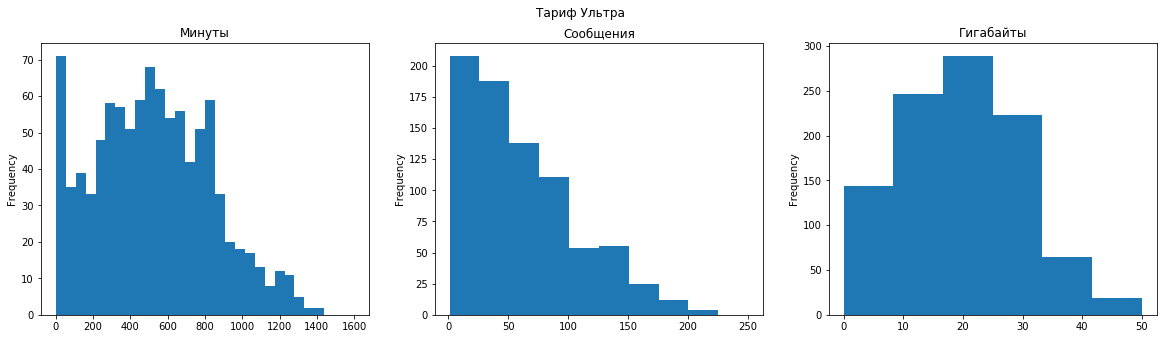

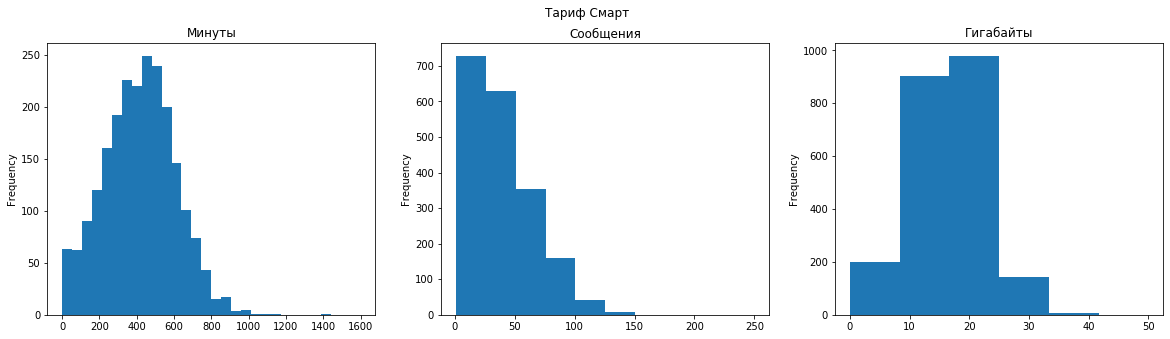

In [7]:

#разбиваю таблицу на две по тарифам
tarif_ultra = tarif_data.query('tariff == "ultra"')
tarif_smart = tarif_data.query('tariff == "smart"')


#гистограммы для тарифа ультра
fig = plt.figure(figsize = (20,5))
fig.suptitle('Тариф Ультра')
ax_1 = fig.add_subplot(1, 3, 1)
ax_2 = fig.add_subplot(1, 3, 2)
ax_3 = fig.add_subplot(1, 3, 3)

tarif_ultra['duration'].plot(ax=ax_1,kind='hist',bins=30, range=(0,1600),  title='Минуты')
tarif_ultra['count_messages'].plot(ax=ax_2,kind='hist',bins=10, range=(1,250),  title='Сообщения')
tarif_ultra['gb_used'].plot(ax=ax_3,kind='hist',bins=6, range=(0,50),  title='Гигабайты')


#гистограммы для тарифа смарт
fig2 = plt.figure(figsize = (20,5))
fig2.suptitle('Тариф Смарт')
ax_4 = fig2.add_subplot(1, 3, 1)
ax_5 = fig2.add_subplot(1, 3, 2)
ax_6 = fig2.add_subplot(1, 3, 3)

tarif_smart['duration'].plot(ax=ax_4,kind='hist',bins=30, range=(0,1600),  title='Минуты')
tarif_smart['count_messages'].plot(ax=ax_5,kind='hist',bins=10, range=(1,250),  title='Сообщения')
tarif_smart['gb_used'].plot(ax=ax_6,kind='hist',bins=6, range=(0,50),  title='Гигабайты')
plt.show()


In [8]:
#Подсчет среднего кол-ва, дисперсии, стандарного отклонения


#Тариф смарт, минуты

var_smart_duration = np.var(tarif_smart['duration'])

mean_smart_duration = tarif_smart['duration'].mean()

normal_smart_duration= mean_smart_duration + 3 * np.sqrt(var_smart_duration)


#Тариф смарт,сообщения

var_smart_messages = np.var(tarif_smart['count_messages'])

mean_smart_messages = tarif_smart['count_messages'].mean()

normal_smart_messages= mean_smart_messages + 3 * np.sqrt(var_smart_messages)


#Тариф смарт, трафик

var_smart_gb = np.var(tarif_smart['gb_used'])

mean_smart_gb = tarif_smart['gb_used'].mean()

normal_smart_gb= mean_smart_gb + 3 * np.sqrt(var_smart_gb)


math_data=pd.DataFrame({'value':['dispertion','mean','normal deviation','three sigma rule'],
                        'duration': [var_smart_duration, mean_smart_duration, np.sqrt(var_smart_duration),normal_smart_duration],
                        'messages': [var_smart_messages,mean_smart_messages,np.sqrt(var_smart_messages),normal_smart_messages],
                        'gb':[var_smart_gb,mean_smart_gb,np.sqrt(var_smart_gb),normal_smart_gb]})

print(math_data)



              value      duration    messages         gb
0        dispertion  36265.124153  796.597877  33.118595
1              mean    417.747534   33.369058  16.321525
2  normal deviation    190.434041   28.224066   5.754876
3  three sigma rule    989.049658  118.041255  33.586152


<b> Вывод </b>

<b> Тариф смарт </b>

1. Среднее значение, которое тратит пользователь на разговоры в месяц - 417 минут. При этом стандартное отклонение равно - 190, по правилу трех сигм, получим, что основному числу пользователей достаточно до 989ти минут в месяц на разговоры.
2.Среднее значение отправленных сообщений в месяц - 33. Стандарное отклонение равно -  28, по правилу трех сигм, получим, что основному числу пользователей достаточно до 118 сообщений в месяц.
3.Среднее значение потраченных ГБ за месяц - 16. Стандартное отклонение = 5. По правилу трех сигм,  получим, что основному числу пользователй хватает до 33 ГБ в месяц интернет трафика.

In [9]:
#Тариф ультра, минуты

var_ultra_duration = np.var(tarif_ultra['duration'])

mean_ultra_duration = tarif_ultra['duration'].mean()

normal_ultra_duration= mean_ultra_duration + 3 * np.sqrt(var_ultra_duration)

#Тариф ультра,сообщения

var_ultra_messages = np.var(tarif_ultra['count_messages'])

mean_ultra_messages = tarif_ultra['count_messages'].mean()

normal_ultra_messages= mean_ultra_messages + 3 * np.sqrt(var_ultra_messages)


#Тариф ультра, трафик

var_ultra_gb = np.var(tarif_ultra['gb_used'])

mean_ultra_gb = tarif_ultra['gb_used'].mean()

normal_ultra_gb= mean_ultra_gb + 3 * np.sqrt(var_ultra_gb)


math_data1=pd.DataFrame({'value':['dispertion','mean','normal deviation','three sigma rule'],
                        'duration': [var_ultra_duration, mean_ultra_duration, np.sqrt(var_ultra_duration),normal_ultra_duration],
                        'messages': [var_ultra_messages,mean_ultra_messages,np.sqrt(var_ultra_messages),normal_ultra_messages],
                        'gb':[var_ultra_gb,mean_ultra_gb,np.sqrt(var_ultra_gb),normal_ultra_gb]})

print(math_data1)


              value       duration     messages         gb
0        dispertion  100950.006233  2283.099557  97.279783
1              mean     526.089249    49.313387  19.474645
2  normal deviation     317.726307    47.781791   9.863051
3  three sigma rule    1479.268171   192.658761  49.063799


<b> Тариф ультра </b>

1. Среднее значение, которое тратит пользователь на разговоры в месяц - 526 минуты. При этом стандартное отклонение равно - 317, по правилу трех сигм, получим, что основному числу пользователей достаточно до 1479 минуты в месяц на разговоры.
2.Среднее значение отправленных сообщений в месяц - 49. Стандарное отклонение равно -  47, по правилу трех сигм, получим, что основному числу пользователей достаточно до 192 сообщений в месяц.
3.Среднее значение потраченных ГБ за месяц - 19. Стандартное отклонение = 9. По правилу трех сигм,  получим, что основному числу пользователй хватает до 49 ГБ в месяц интернет трафика.

# 4. Проверка гипотез

In [10]:
#Гипотеза -средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
#Нулевая гипотеза - средняя выручка пользователе тарифов равна.
from scipy.stats import bartlett


print('Средняя выручка тарифа ультра:', tarif_ultra['profit'].mean())
print('Средняя выручка тарифа смарт:',tarif_smart['profit'].mean())


alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(tarif_ultra['profit'], tarif_smart['profit'],equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Подтверждаем, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются ')
else:
    print('Отвергаем гипотезу') 
    
stat, p = bartlett(tarif_ultra['profit'],tarif_smart['profit'])


Средняя выручка тарифа ультра: 1950.0
Средняя выручка тарифа смарт: 692.1529147982063
p-значение: 0.0
Подтверждаем, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются 


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:2241: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)




H0:Средняя выручка двух тарифов равна
    
Н1:Средняя выручка пользователей различаются
    
Подтверждаем альтернативную гипотезу

In [11]:
#Гипотеза - средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.
#Нулевая гипотеза - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

user_moscow = tarif_data.query('city == "Москва"')
user_other = tarif_data.query('city != "Москва"')


print('Средняя выручка пользователей из Москвы:', user_moscow['profit'].mean())
print('Средняя выручка пользователей из других регионов:',user_other['profit'].mean())


alpha = 0.05  # критический уровень статистической значимости

results_1 = st.ttest_ind(user_moscow['profit'], user_other['profit'],equal_var=False)

print('p-значение:', results_1.pvalue)

if results_1.pvalue < alpha:
    print('Подтверждаем, средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов. ')
else:
    print('Отвергаем гипотезу') 
    
    
stat, pi = bartlett(user_moscow['profit'],user_other['profit'])




Средняя выручка пользователей из Москвы: 1147.859247135843
Средняя выручка пользователей из других регионов: 1061.3662188099809
p-значение: 0.0025424121881247076
Подтверждаем, средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов. 


# 5. Общий вывод

Основное количество пользователей тарифа Смарт и тарифа Ультра тратят практически одинаковое кол-во интернет трафика и сообщений в месяц. Для пользователей тарифа смарт достаточно 63х минут разговора в месяц, а для тарифа ультра 81. При этом с учетом расценок тарифов, если пользователи с тарифа Ультра перейдут на Смарт - им будет выгоднее.

Основной процент клиентов не израсходывают весь трафик, сообщения и минуты включенные в стоимость тарифа и не платят сверх нормы.

При этом средняя выручка тарифа ультра практически в три раза выше средней выручки тарифа смарт. Но число пользователей в выборке с тарифом смарт = 24456 , с тарифом ультра = 9786. Что означает, что тарифом смарт пользуются в 2,4 раза больше пользователей.



1543501.0
1922700.0


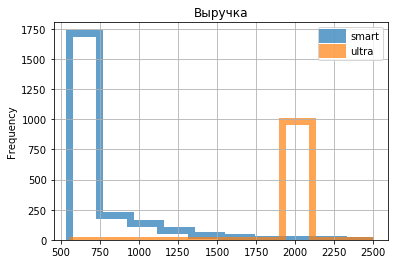

In [12]:
#сравнение выручки от тарифов

ах= tarif_smart.plot(
    kind='hist',
    y='profit',
    histtype='step',
    bins=10,
    linewidth=7,
    alpha=0.7,
    range = (550,2500),
    label='smart',
    title='Выручка'
)
tarif_ultra.plot(
    kind='hist',
    y='profit',
    histtype='step',
    bins=10,
    linewidth=7,
    alpha=0.7,
    range = (550,2500),
    label='ultra',
    ax=ах,
    grid=True,
    legend=True,
)

print(tarif_smart['profit'].sum())
print(tarif_ultra['profit'].sum())


    
Вывод:

    1.Основное число пользователей тарифа смарт тратят : до 989 минут на звонки в месяц, до 118 сообщений, до 33 ГБ интернета в месяц. При этом средняя выручка в месяц составляет - 692 рубля.

    2.Основное число пользователей тарифа ультра тратят: до 1479 минут на звонки в месяц, до 192 сообщений, до 49 ГБ интернета. Средняя выручка составляет 1950 руб.
    
    3. Средняя выручка пользователей тарифа Ультра в 3 раза больше выручки от тарифа Смарт, при  этом клиентов, кто пользуется данным тарифом меньше в 2,2 раза. 
    
    4.При этом если брать разницу в количестве клиентов по каждому тарифу, выручка от пользователей тарифа Ультра выше выручки тарифа Смарт.
    
    5. Больше дополнительной выручки приносят пользователеф тарифа Смарт, так как тратят больше, чем включено в основной тариф. Средняя выручка по тарифу смарт не равна цене основного тарифа, именно за счет дополнительной выручки она выше.
    